### EMA(지수이동 평균)
- 최근 데이터에 더 큰 가중치를 부여하여 계산
- sma에 비해 최근 변화에 더 민감하게 반응
- 지수 가중치를 사용하여 과거 데이터의 영향력을 점진적으로 줄여가며 계산


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, auc, precision_recall_curve, confusion_matrix,
                           classification_report, average_precision_score)
from sklearn.calibration import calibration_curve
from itertools import cycle

In [3]:
data = pd.read_csv('/content/drive/MyDrive/jong_su/merged_V2.csv')
df = data

In [4]:
# EMA를 적용할 좌표 열 리스트
coordinate_columns = [col for col in df.columns if '_x' in col or '_y' in col]

# EMA 계산 함수
def apply_ema(df, window_size):
    return df.ewm(span=window_size, adjust=False).mean()

# window size 설정 (예: 10 프레임)
window_size = 10

# 각 좌표 열에 대해 EMA 적용
for col in coordinate_columns:
    df[f"{col}_EMA"] = apply_ema(df[col], window_size)

df.head()


,image_filename,Nose_x,Nose_y,LEye_x,LEye_y,REye_x,REye_y,LEar_x,LEar_y,REar_x,...,RBigToe_x_EMA,RBigToe_y_EMA,LSmallToe_x_EMA,LSmallToe_y_EMA,RSmallToe_x_EMA,RSmallToe_y_EMA,LHeel_x_EMA,LHeel_y_EMA,RHeel_x_EMA,RHeel_y_EMA
0,0.jpg,1368.317139,245.318161,1375.947510,242.774719,1368.317139,240.231262,1388.664673,245.318161,1386.121338,...,1355.599976,466.598053,1360.686768,466.598053,1355.599976,464.054596,1383.577881,456.424255,1386.121338,456.424255
1,1.jpg,1367.379517,245.956863,1375.112671,240.801453,1367.379517,240.801453,1388.001221,245.956863,1385.423462,...,1355.398338,466.318701,1360.497625,466.787373,1355.398338,463.769012,1383.913441,456.588662,1385.994451,456.588662
2,2.jpg,1365.833862,248.601212,1373.505005,243.487152,1365.833862,243.487152,1386.290161,246.044174,1383.733032,...,1355.436064,466.251394,1360.073119,466.634854,1355.436064,463.700370,1383.415729,456.895712,1386.513127,456.430796
3,3.jpg,1365.026855,247.695007,1372.763184,242.537491,1365.026855,242.537491,1385.656982,247.695007,1380.499390,...,1355.304401,466.367369,1360.036077,466.681108,1355.304401,463.811306,1382.885486,457.306125,1386.826325,456.456878
4,4.jpg,1362.091553,247.426620,1369.815674,242.277222,1364.666260,239.702530,1382.689209,247.426620,1380.114502,...,1355.134043,466.350767,1359.941671,466.607463,1355.134043,463.791320,1383.786056,457.532642,1387.010380,456.369676


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


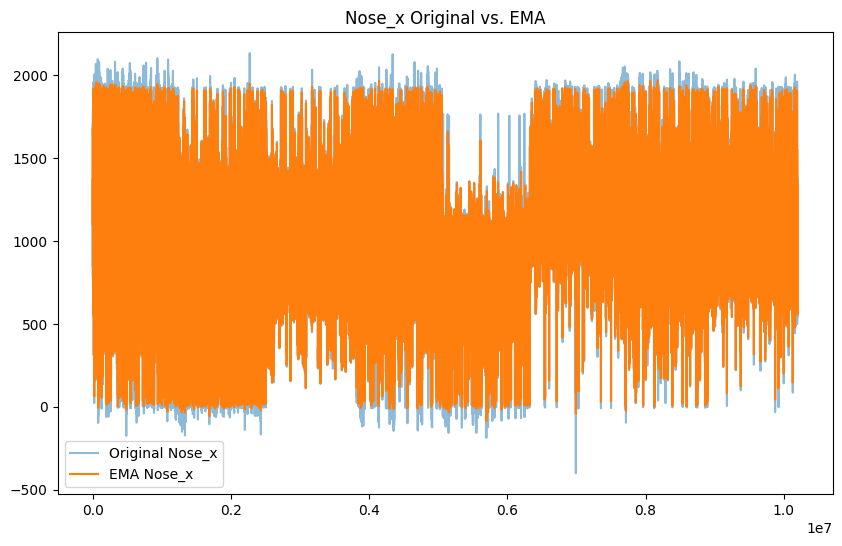

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(data['Nose_x'], label='Original Nose_x', alpha=0.5)
plt.plot(data['Nose_x_EMA'], label='EMA Nose_x')
plt.legend()
plt.title("Nose_x Original vs. EMA")
plt.show()

In [6]:
df = df.drop(['image_filename', 'Nose_x', 'Nose_y', 'LEye_x', 'LEye_y', 'REye_x', 'REye_y', 'LEar_x', 'LEar_y', 'REar_x', 'REar_y', 'LShoulder_x', 'LShoulder_y', 'RShoulder_x', 'RShoulder_y', 'LElbow_x', 'LElbow_y', 'RElbow_x', 'RElbow_y', 'LWrist_x', 'LWrist_y', 'RWrist_x', 'RWrist_y', 'LHip_x', 'LHip_y', 'RHip_x', 'RHip_y', 'LKnee_x', 'LKnee_y', 'RKnee_x', 'RKnee_y', 'LAnkle_x', 'LAnkle_y', 'RAnkle_x', 'RAnkle_y', 'Head_x', 'Head_y', 'Neck_x', 'Neck_y', 'Hip_x', 'Hip_y', 'LBigToe_x', 'LBigToe_y', 'RBigToe_x', 'RBigToe_y', 'LSmallToe_x', 'LSmallToe_y', 'RSmallToe_x', 'RSmallToe_y', 'LHeel_x', 'LHeel_y', 'RHeel_x', 'RHeel_y', 'gender', 'level','path'], axis=1)
df.head()

,label,Nose_x_EMA,Nose_y_EMA,LEye_x_EMA,LEye_y_EMA,REye_x_EMA,REye_y_EMA,LEar_x_EMA,LEar_y_EMA,REar_x_EMA,...,RBigToe_x_EMA,RBigToe_y_EMA,LSmallToe_x_EMA,LSmallToe_y_EMA,RSmallToe_x_EMA,RSmallToe_y_EMA,LHeel_x_EMA,LHeel_y_EMA,RHeel_x_EMA,RHeel_y_EMA
0,Jump,1368.317139,245.318161,1375.947510,242.774719,1368.317139,240.231262,1388.664673,245.318161,1386.121338,...,1355.599976,466.598053,1360.686768,466.598053,1355.599976,464.054596,1383.577881,456.424255,1386.121338,456.424255
1,Jump,1368.146662,245.434289,1375.795721,242.415943,1368.146662,240.334933,1388.544045,245.434289,1385.994451,...,1355.398338,466.318701,1360.497625,466.787373,1355.398338,463.769012,1383.913441,456.588662,1385.994451,456.588662
2,Jump,1367.726153,246.010093,1375.379227,242.610709,1367.726153,240.908064,1388.134248,245.545177,1385.583284,...,1355.436064,466.251394,1360.073119,466.634854,1355.436064,463.700370,1383.415729,456.895712,1386.513127,456.430796
3,Jump,1367.235372,246.316441,1374.903583,242.597396,1367.235372,241.204323,1387.683836,245.936055,1384.658940,...,1355.304401,466.367369,1360.036077,466.681108,1355.304401,463.811306,1382.885486,457.306125,1386.826325,456.456878
4,Jump,1366.300132,246.518292,1373.978508,242.539183,1366.768260,240.931270,1386.775722,246.207067,1383.832678,...,1355.134043,466.350767,1359.941671,466.607463,1355.134043,463.791320,1383.786056,457.532642,1387.010380,456.369676


In [7]:
print(list(df.columns))

['label', 'Nose_x_EMA', 'Nose_y_EMA', 'LEye_x_EMA', 'LEye_y_EMA', 'REye_x_EMA', 'REye_y_EMA', 'LEar_x_EMA', 'LEar_y_EMA', 'REar_x_EMA', 'REar_y_EMA', 'LShoulder_x_EMA', 'LShoulder_y_EMA', 'RShoulder_x_EMA', 'RShoulder_y_EMA', 'LElbow_x_EMA', 'LElbow_y_EMA', 'RElbow_x_EMA', 'RElbow_y_EMA', 'LWrist_x_EMA', 'LWrist_y_EMA', 'RWrist_x_EMA', 'RWrist_y_EMA', 'LHip_x_EMA', 'LHip_y_EMA', 'RHip_x_EMA', 'RHip_y_EMA', 'LKnee_x_EMA', 'LKnee_y_EMA', 'RKnee_x_EMA', 'RKnee_y_EMA', 'LAnkle_x_EMA', 'LAnkle_y_EMA', 'RAnkle_x_EMA', 'RAnkle_y_EMA', 'Head_x_EMA', 'Head_y_EMA', 'Neck_x_EMA', 'Neck_y_EMA', 'Hip_x_EMA', 'Hip_y_EMA', 'LBigToe_x_EMA', 'LBigToe_y_EMA', 'RBigToe_x_EMA', 'RBigToe_y_EMA', 'LSmallToe_x_EMA', 'LSmallToe_y_EMA', 'RSmallToe_x_EMA', 'RSmallToe_y_EMA', 'LHeel_x_EMA', 'LHeel_y_EMA', 'RHeel_x_EMA', 'RHeel_y_EMA']


In [8]:
X = df.drop(['label'], axis=1)
Y = df['label']

print(X.shape)
print(Y.shape)

(10196123, 52)
(10196123,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(6525518, 52) (1631380, 52) (2039225, 52) (6525518,) (1631380,) (2039225,)


In [10]:
model = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

In [11]:
fold = KFold(n_splits=5, shuffle=False)
cv_scores = cross_val_score(model, X_train, y_train, cv=fold, scoring='accuracy')
print("\n=== Cross-validation Scores ===")
print(f"CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# 5. 최종 모델 훈련
print("\n=== Training Final Model ===")
model.fit(X_train, y_train)
print("Model training completed!")

# 6. 훈련 세트 성능 평가
y_train_pred = model.predict(X_train)
print("\n=== Training Set Performance ===")
print(classification_report(y_train, y_train_pred))

# 검증 세트 성능 평가
y_val_pred = model.predict(X_val)
print("\n=== Validation Set Performance ===")
print(classification_report(y_val, y_val_pred))

# 7. 테스트 세트 성능 평가
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)
print("\n=== Test Set Performance ===")
print(classification_report(y_test, y_test_pred))


=== Cross-validation Scores ===
CV Accuracy: 0.899 (+/- 0.001)

=== Training Final Model ===
Model training completed!

=== Training Set Performance ===
              precision    recall  f1-score   support

        Jump       1.00      1.00      1.00   2947537
        Spin       1.00      1.00      1.00   2102274
        Step       1.00      1.00      1.00   1475707

    accuracy                           1.00   6525518
   macro avg       1.00      1.00      1.00   6525518
weighted avg       1.00      1.00      1.00   6525518


=== Validation Set Performance ===
              precision    recall  f1-score   support

        Jump       0.90      0.94      0.92    736885
        Spin       0.92      0.90      0.91    525568
        Step       0.93      0.87      0.90    368927

    accuracy                           0.91   1631380
   macro avg       0.92      0.90      0.91   1631380
weighted avg       0.91      0.91      0.91   1631380


=== Test Set Performance ===
              prec

coufusion Matrix


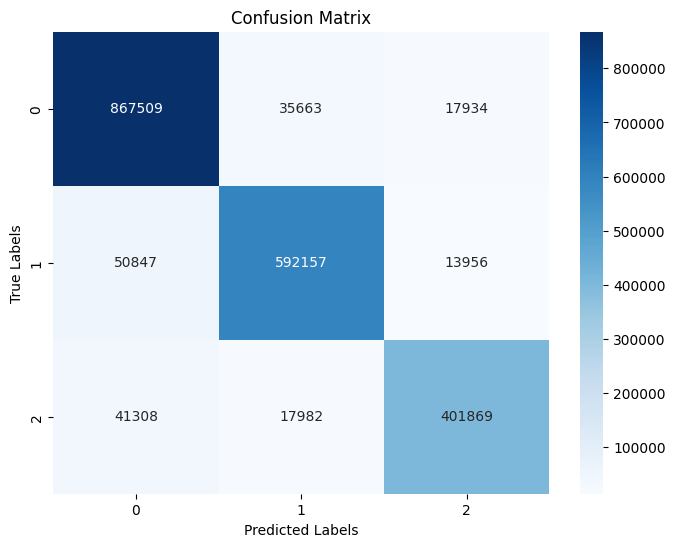

In [12]:
print("coufusion Matrix")
y_test_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

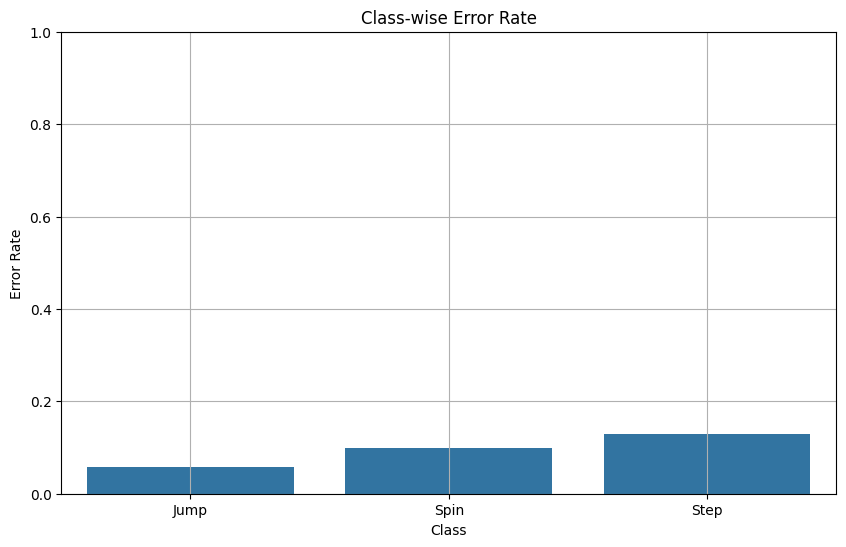

Class-wise Error Rate:
True Label
Jump    0.058188
Spin    0.098641
Step    0.128567
Name: Error, dtype: float64


In [13]:
error = pd.DataFrame({
    "True Label": y_test,
    "predicted Label": y_test_pred
})

error["Error"] = (error["True Label"] != error["predicted Label"]).astype(int)

#클래스별 오류 비율
class_error_rate = error.groupby("True Label")["Error"].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_error_rate.index, y=class_error_rate.values)
plt.title("Class-wise Error Rate")
plt.xlabel("Class")
plt.ylabel("Error Rate")
plt.ylim(0,1)
plt.grid(True)
plt.show()

print("Class-wise Error Rate:")
print(class_error_rate)

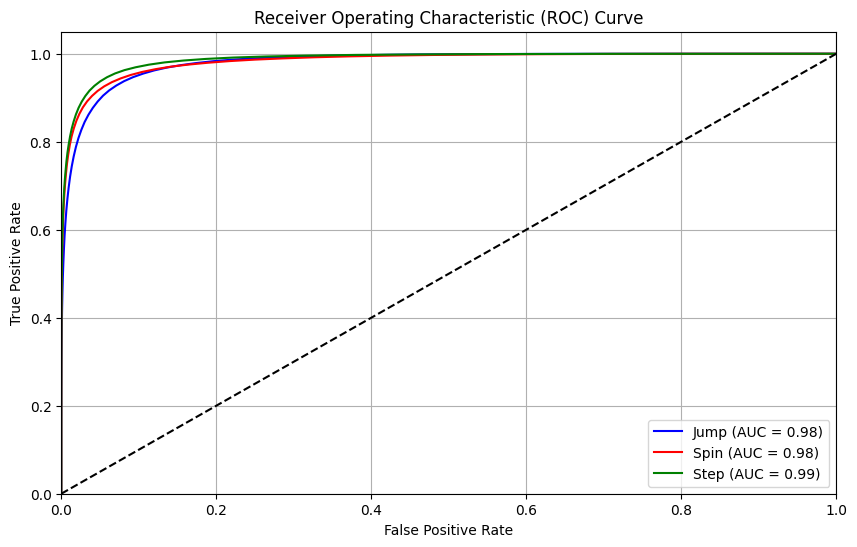


ROC AUC Scores:
Jump: 0.981
Spin: 0.983
Step: 0.987


In [14]:
# roc
plt.figure(figsize=(10,6))
y_pred_proba = model.predict_proba(X_test)
n_classes = len(np.unique(Y))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_name in enumerate(np.unique(Y)):
    fpr[i], tpr[i], _ = roc_curve(
        (y_test == class_name).astype(int),
        y_pred_proba[:, i]
    )
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i,  (color, class_name) in enumerate(zip(colors, np.unique(Y))):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label=f"{class_name} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nROC AUC Scores:")
for i, class_name in enumerate(np.unique(Y)):
    print(f"{class_name}: {roc_auc[i]:.3f}")


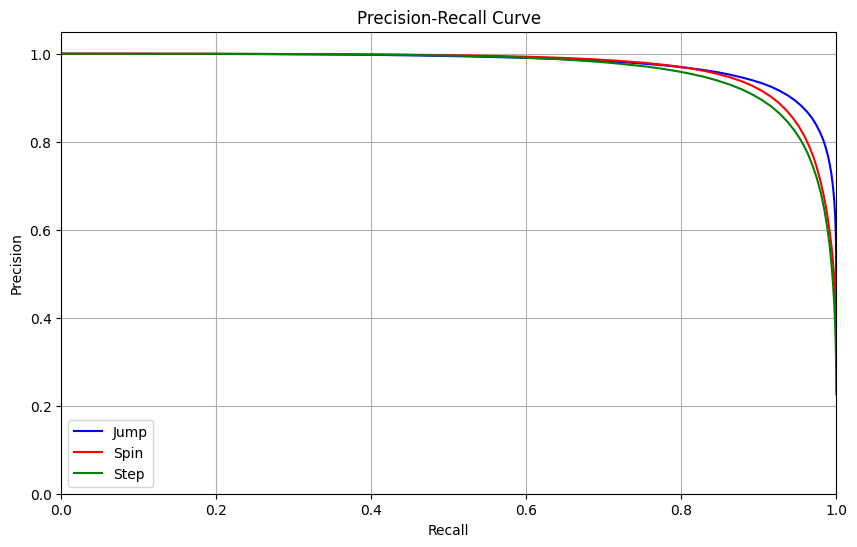


Average Precision Scores:
Jump: 0.976
Spin: 0.969
Step: 0.963


In [18]:
#pr
plt.figure(figsize=(10,6))
precision = dict()
recall = dict()
avg_precision = dict()

for i, class_name in enumerate(np.unique(Y)):
    precision[i], recall[i], _ = precision_recall_curve(
        (y_test == class_name).astype(int),
        y_pred_proba[:, i]
    )
    avg_precision[i] = average_precision_score(
        (y_test == class_name).astype(int),
        y_pred_proba[:, i]
    )

colors = cycle(['blue', 'red', 'green'])
for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
    plt.plot(
        recall[i],
        precision[i],
        color=color,
        label=f"{class_name}"
    )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print("\nAverage Precision Scores:")
for i, class_name in enumerate(np.unique(Y)):
    print(f"{class_name}: {avg_precision[i]:.3f}")

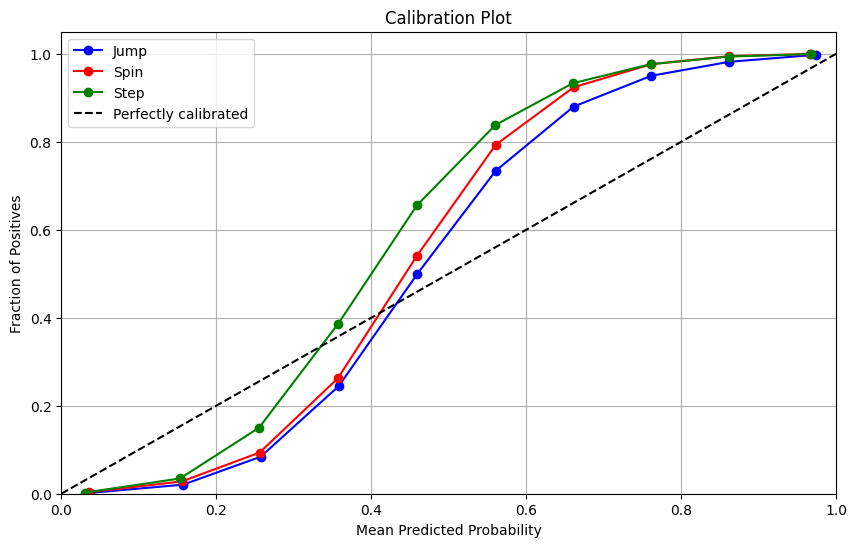


=== Calibration Scores (Mean Absolute Error) ===
Jump: 0.1223
Spin: 0.1375
Step: 0.1407


In [16]:
# 신뢰도
plt.figure(figsize=(10,6))
n_classes = len(np.unique(Y))
prob_true = dict()
prob_pred = dict()
calibration_scores = dict()

colors = cycle(['blue', 'red', 'green'])
for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
    prob_true[i], prob_pred[i] = calibration_curve(
        (y_test == class_name).astype(int),
        y_pred_proba[:, i],
        n_bins=10
    )

    plt.plot(
        prob_pred[i],
        prob_true[i],
        marker='o',
        color=color,
        label=f"{class_name}"
    )
    # 절대오차의 평균으로 신뢰도 계산
    calibration_scores[i] = np.mean(np.abs(prob_true[i] - prob_pred[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend(loc="best")
plt.grid(True)
plt.show()

# 신뢰도 출력
print("\n=== Calibration Scores (Mean Absolute Error) ===")
for i, class_name in enumerate(np.unique(Y)):
    print(f"{class_name}: {calibration_scores[i]:.4f}")



<ipython-input-17-430a1f0a90ff>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


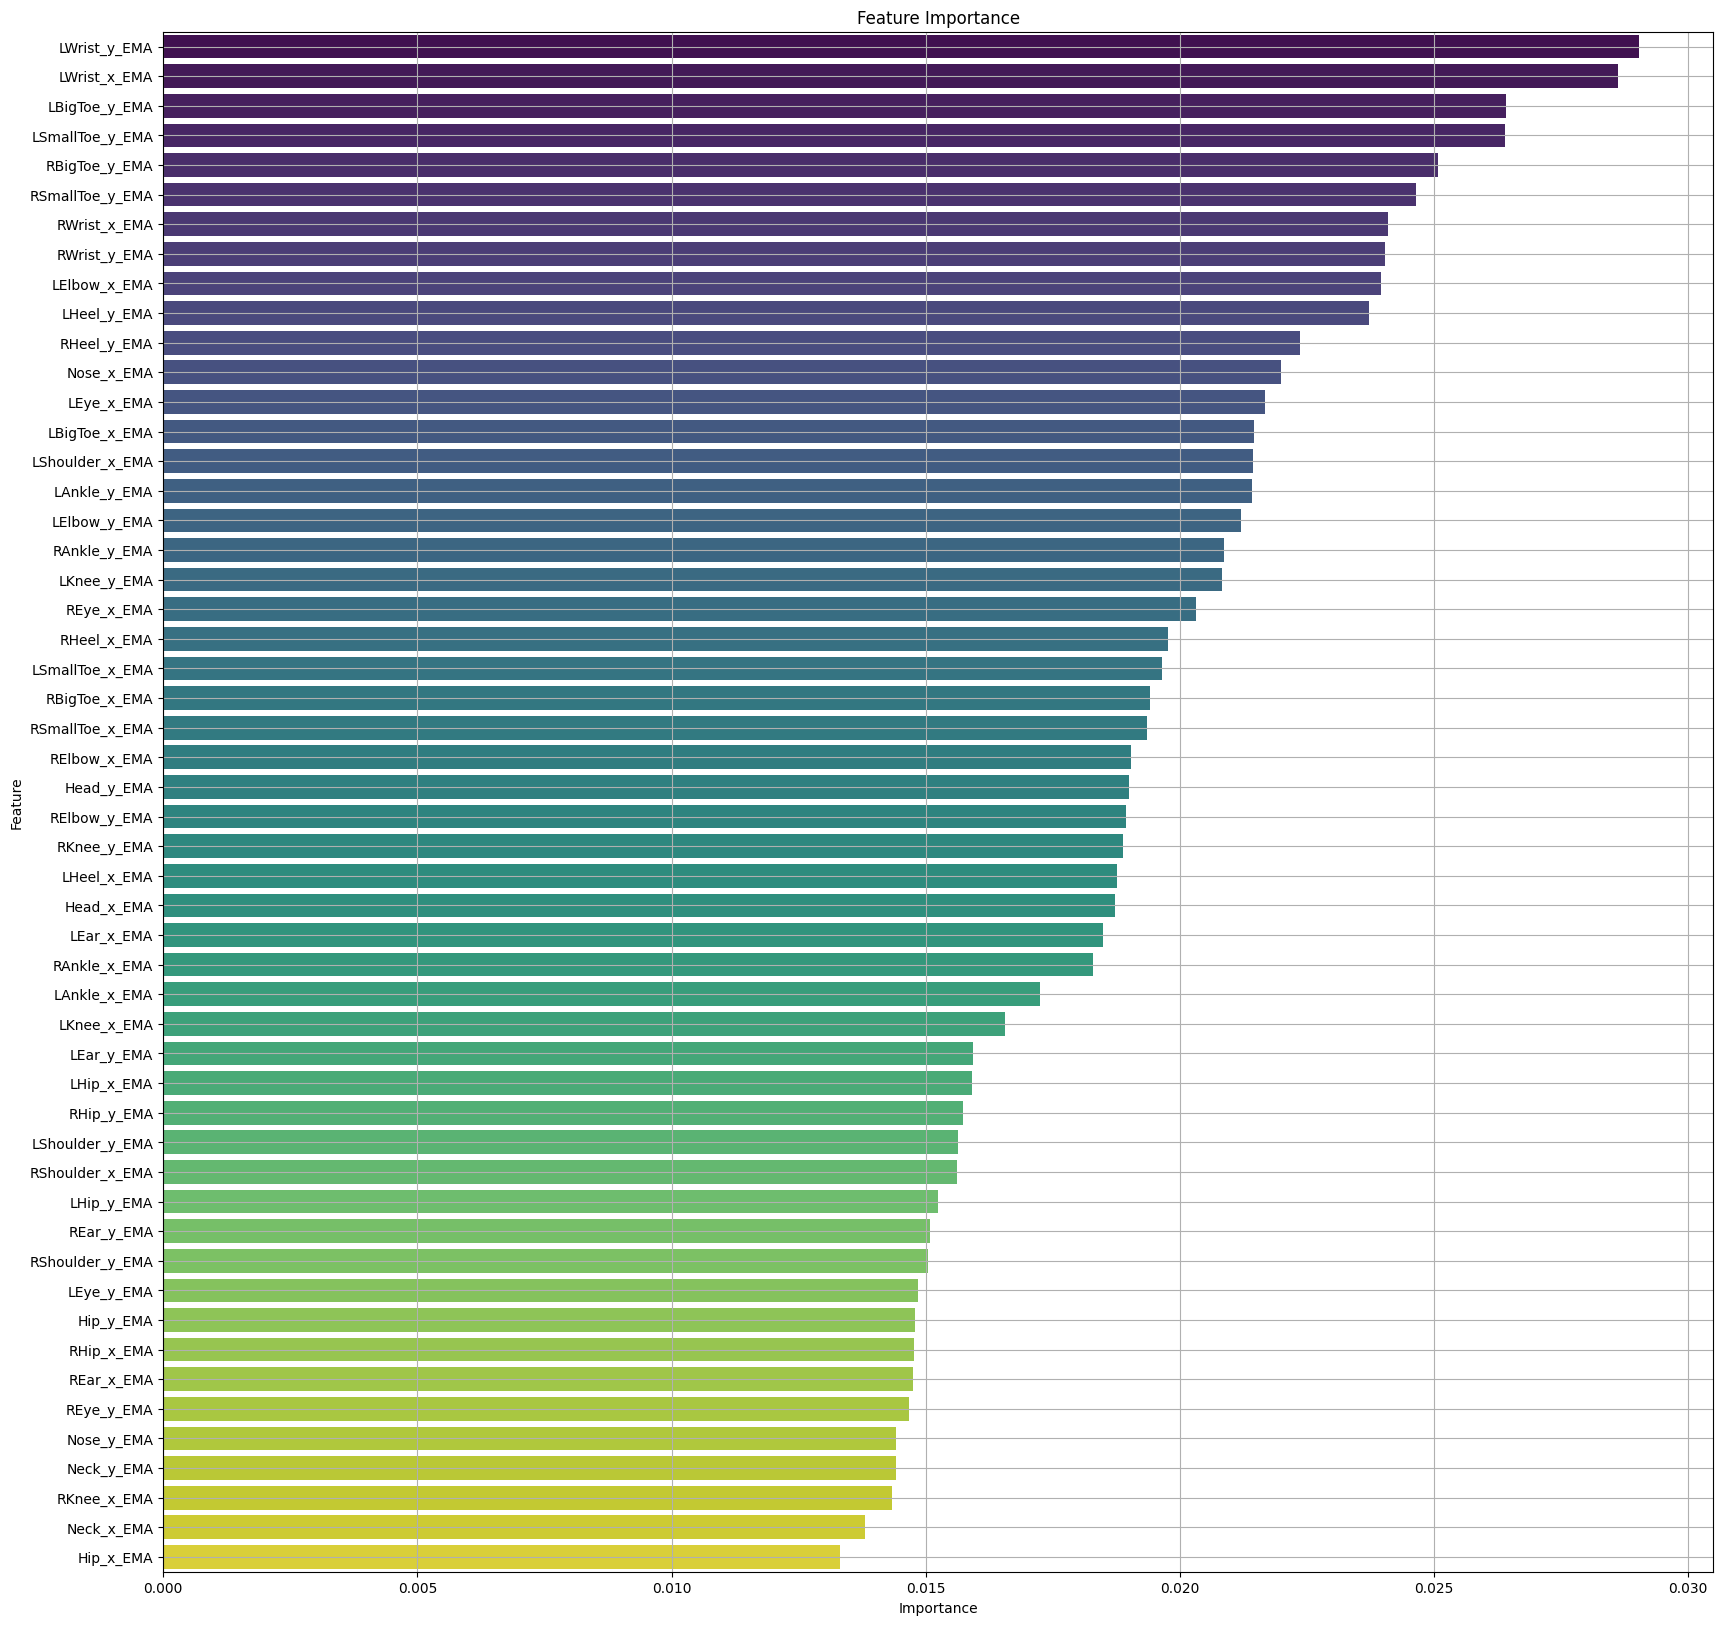


=== Feature Importance ===
            Feature  Importance
19     LWrist_y_EMA    0.029038
18     LWrist_x_EMA    0.028614
41    LBigToe_y_EMA    0.026414
45  LSmallToe_y_EMA    0.026387
43    RBigToe_y_EMA    0.025087
47  RSmallToe_y_EMA    0.024653
20     RWrist_x_EMA    0.024097
21     RWrist_y_EMA    0.024038
14     LElbow_x_EMA    0.023953
49      LHeel_y_EMA    0.023713
51      RHeel_y_EMA    0.022361
0        Nose_x_EMA    0.021990
2        LEye_x_EMA    0.021677
40    LBigToe_x_EMA    0.021466
10  LShoulder_x_EMA    0.021431
31     LAnkle_y_EMA    0.021410
15     LElbow_y_EMA    0.021207
33     RAnkle_y_EMA    0.020867
27      LKnee_y_EMA    0.020834
4        REye_x_EMA    0.020319


In [17]:
importance = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 20))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

print("\n=== Feature Importance ===")
print(importance_df.head(20))